In [1]:
# For Google Colaboratory

#!pip install torchinfo
#!unzip training.zip

In [2]:
#!conda env export > environment.yml

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import os

from road_segmentation.utils import *

In [4]:
import warnings

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    warnings.warn("CUDA not detected, training will be very slow")

device = torch.device(device)

# Dataset loading

In [5]:
IMAGE_SRC_DIR = "data/training/images/"
IMAGE_GT_DIR = "data/training/groundtruth/"

IMAGES_SRC = np.asarray(read_all_images(IMAGE_SRC_DIR))
IMAGES_GT = np.asarray(read_all_images(IMAGE_GT_DIR))

IMAGES_SRC.shape

(100, 400, 400, 3)

In [6]:
#IMAGES_SRC = IMAGES_SRC[:10, ...]
#IMAGES_GT = IMAGES_GT[:10, ...]

# Augment data

Testing multiple examples

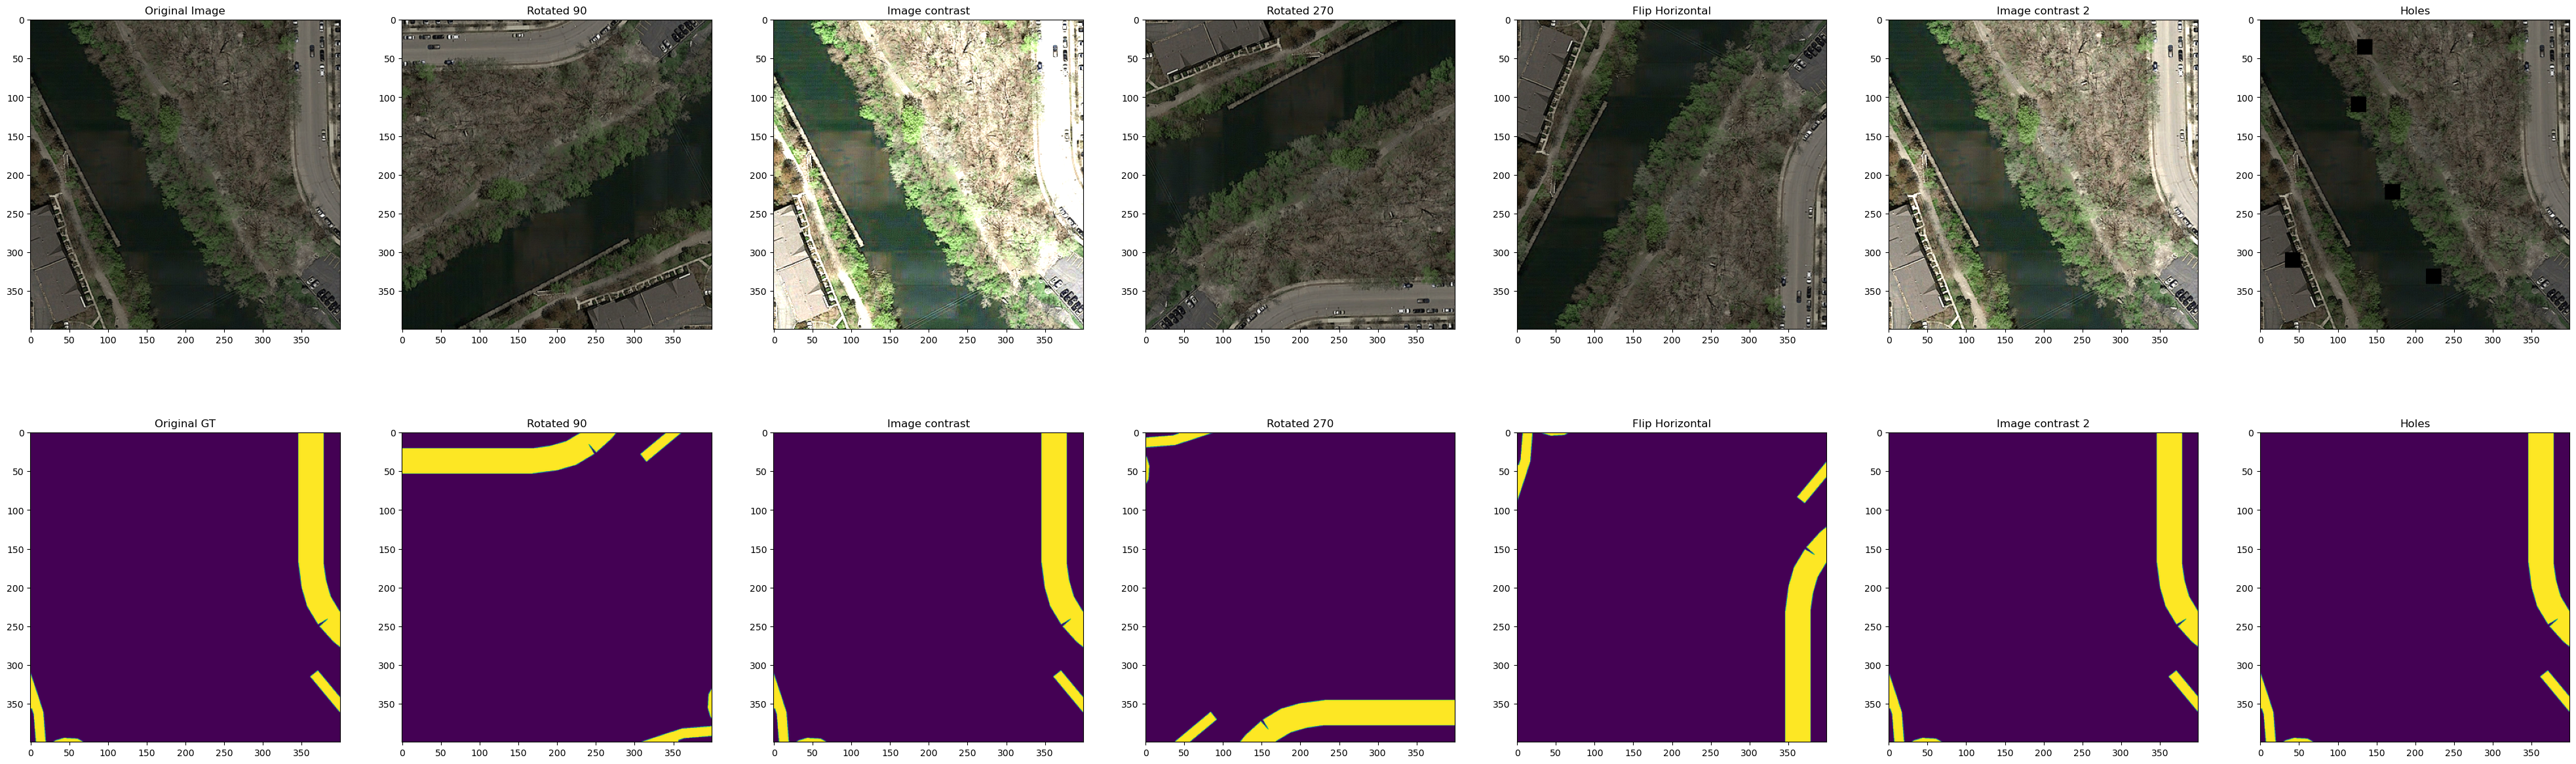

In [7]:
visualize_augmented_data(IMAGES_SRC[:-5:-1], IMAGES_GT[:-5:-1])

In [8]:
augmented_src, augmented_gt = augment_data(IMAGES_SRC, IMAGES_GT)
#augmented_src, augmented_gt = IMAGES_SRC, IMAGES_GT
print(augmented_src.shape)
print(augmented_gt.shape)

(1100, 400, 400, 3)
(1100, 400, 400)


## crop

In [9]:
PATCH_SIZE = 100
cropped_src, cropped_gt = np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src]).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)), np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt]).reshape((-1, PATCH_SIZE, PATCH_SIZE))
print(cropped_src.shape)
print(cropped_gt.shape)

(17600, 100, 100, 3)
(17600, 100, 100)


# Normalization

In [10]:
def get_mean_std(imgs):
  """
  Normalizes images with mean and standard deviation, by channel
  """
  mean = imgs.mean(axis=(0, 1, 2))
  std = imgs.std(axis=(0, 1, 2))

  return mean, std

means, stds = get_mean_std(cropped_src)

# Dataset loading

In [11]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

ds_src, ds_gt = torch.stack([img_transform(i) for i in cropped_src]), torch.stack([transforms.ToTensor()(i) for i in cropped_gt]).squeeze()
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([17600, 3, 100, 100])
torch.Size([17600, 100, 100])


In [12]:
dataset = TensorDataset(ds_src.to(device), ds_gt.to(device))

## + splitting

In [13]:
def split_dataset(dataset):
  train_size = int(len(dataset) * 0.8)
  test_size = len(dataset) - train_size
  return torch.utils.data.random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(dataset)

# Model definition

In [14]:
from road_segmentation.models import UNet, RefinedUnet

model=UNet(n_channels=3, n_classes=1)
summary(model, input_size=(6, 3, PATCH_SIZE, PATCH_SIZE))

net=UNet(n_channels=4, n_classes=1)

model1=RefinedUnet(n=1, net=net)
model2=RefinedUnet(n=2, net=net)
model3=RefinedUnet(n=3, net=net)

summary(model2, input_size=(6, 3, PATCH_SIZE, PATCH_SIZE))

Layer (type:depth-idx)                             Output Shape              Param #
RefinedUnet                                        [6, 1, 100, 100]          --
├─UNet: 1-1                                        [6, 100, 100]             --
│    └─DoubleConv: 2-1                             [6, 64, 100, 100]         --
│    │    └─Sequential: 3-1                        [6, 64, 100, 100]         39,424
│    └─Down: 2-2                                   [6, 128, 50, 50]          --
│    │    └─Sequential: 3-2                        [6, 128, 50, 50]          221,696
│    └─Down: 2-3                                   [6, 256, 25, 25]          --
│    │    └─Sequential: 3-3                        [6, 256, 25, 25]          885,760
│    └─Down: 2-4                                   [6, 512, 12, 12]          --
│    │    └─Sequential: 3-4                        [6, 512, 12, 12]          3,540,992
│    └─Down: 2-5                                   [6, 1024, 6, 6]           --
│    │    └─Se

# Training!

In [15]:
from tqdm.notebook import tqdm
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    t = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, target) in t:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data).squeeze()#[None, ...]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        t.set_postfix({"loss": loss.item()})
        acc_history.append(((output > 0).eq(target > 0).sum() / target.numel()).item())

    return acc_history, loss_history

In [51]:
def train(device, model, batch_size=32, epochs=60, lr=0.002):
    pytorchDl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for i in tqdm(range(epochs)):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        if i % 1 == 0:
          print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))
        if i%1==0:
          print("saving…")
          torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))
        if i%1 == 0:
          #f1 = compute_f1(test_ds, model, device, threshold=0.10)
          #print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.18)
          print("F1: ", f1)
          #f1 = compute_f1(test_ds, model, device, threshold=0.25)
          #print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.5)
          print("F1: ", f1)
          #f1 = compute_f1(test_ds, model, device, threshold=0.75)
          #print("F1: ", f1)

    return
  
def train_chain(device, batch_size=32, epochs=60, lr=0.002):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    model1.to(device)
    model2.to(device)
    model3.to(device)
    
    model1.train()
    model2.train()
    model3.train()
    
    optimizer1 = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer2 = torch.optim.Adam(model.parameters(), lr=lr/1.5)
    optimizer3 = torch.optim.Adam(model.parameters(), lr=lr/2)
    
    criterion = nn.BCEWithLogitsLoss()

    for i in tqdm(range(epochs)):
        loss_history = []
        acc_history = []
        t = tqdm(enumerate(train_loader), total=len(train_loader))
        
        for batch_idx, (data, target) in t:
            data, target = data.to(device), target.to(device)
            
            r = 0 if batch_idx%10 < 7 else 1 if batch_idx < 9 else 2
            
            if r == 0:
              optimizer1.zero_grad()
              output = model1.forward(data).squeeze()
            
              loss = criterion(output, target)
              loss.backward()
              optimizer1.step()
            elif r == 1:
              optimizer2.zero_grad()
              output = model2.forward(data).squeeze()
            
              loss = criterion(output, target)
              loss.backward()
              optimizer2.step()
            else:
              optimizer3.zero_grad()
              output = model3.forward(data).squeeze()
            
              loss = criterion(output, target)
              loss.backward()
              optimizer3.step()

            loss_history.append(loss.item())
            t.set_postfix({"loss": loss.item()})
            acc_history.append(((output > 0).eq(target > 0).sum() / target.numel()).item())

        if i % 1 == 0:
          print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))
        if i%1==0:
          print("saving…")
          torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))
        if i%1 == 0:
          #f1 = compute_f1(test_ds, model, device, threshold=0.10)
          #print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.18)
          print("F1: ", f1)
          #f1 = compute_f1(test_ds, model, device, threshold=0.25)
          #print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.5)
          print("F1: ", f1)
          #f1 = compute_f1(test_ds, model, device, threshold=0.75)
          #print("F1: ", f1)

    return

In [54]:
#model.load_state_dict(torch.load("checkpoints/antoine_last.pt"))
#torch.save(model.state_dict(), "./checkpoints/antoine_last.pt")

#net.load_state_dict(torch.load("checkpoints/model_net_antoine_last.pt"))
#torch.save(net.state_dict(), "./checkpoints/model_net_antoine_last.pt")

<All keys matched successfully>

In [58]:
train(device, model3, 16, 5, 0.001)
#train_chain(device, 32, 10, 0.002)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

# Visualize results?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


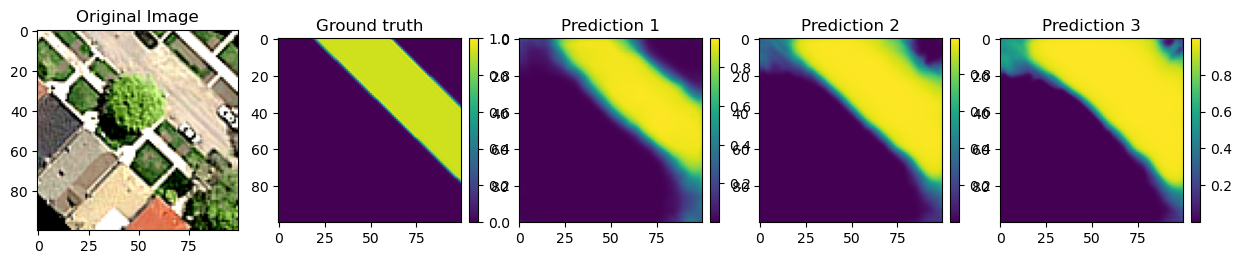

In [55]:
#visualize_result(device, model, train_ds)
#visualize_result(device, model, test_ds)

from road_segmentation.utils.visualization import *
visualize_stages(device, model3, train_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


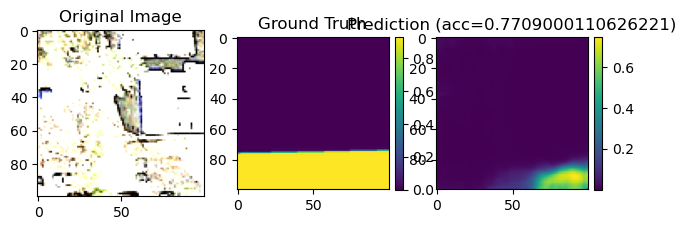

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


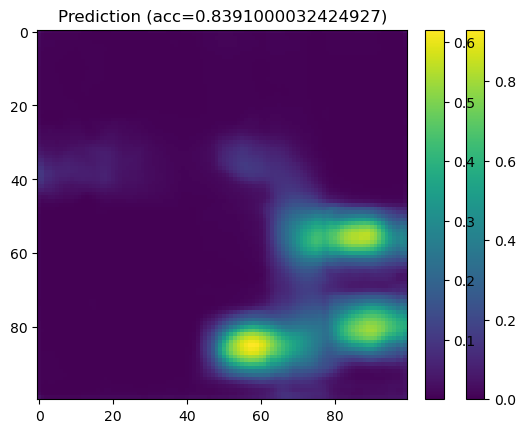

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


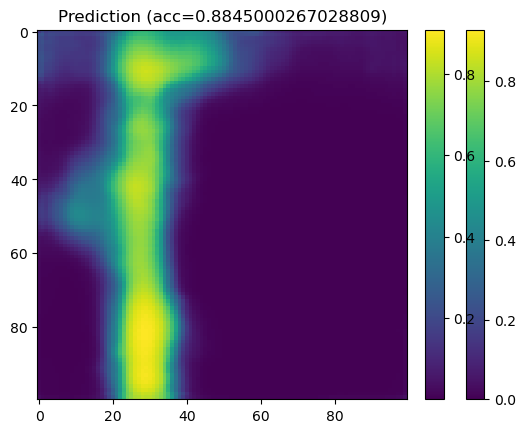

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


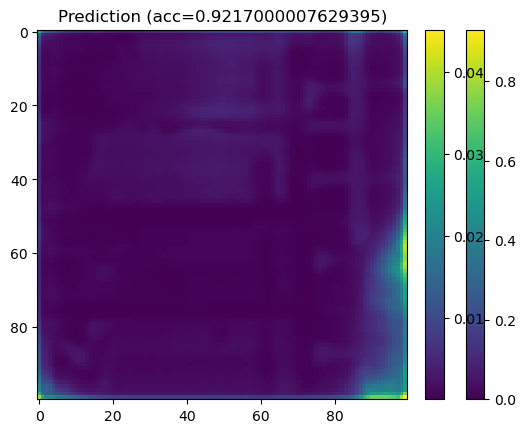

In [37]:
dl = DataLoader(train_ds, batch_size=2, shuffle=True)

N = 4 #1000

acc_dict = {}

for batch_idx, (data, target) in enumerate(dl):
    data, target = data.to(device), target.to(device)
    output = model3.forward(data)
    output = output[0]

    acc = ((output > 0).eq(target[0] > 0).sum() / target[0].numel()).item() # TODO: change to F1 score

    acc_dict[acc] = (data, target)

    if batch_idx >= N:
      break

k = 4
top_k = []

accs = sorted(list(acc_dict.keys()))

top_k = [
    (accs[i], acc_dict[accs[i]])
    for i in range(min(len(accs), k))
]

m = len(top_k)

from math import ceil
cols = 3*2 # 2 sets of 3 images
rows = ceil(m/2)

fig = plt.figure(figsize=(15, 15))

for i, (acc, (data, target)) in enumerate(top_k):
    idx = i*3

    data = data.squeeze()
    target = target.squeeze()

    inputs = data.to(device)

    output = model3.forward(inputs)[0]

    data, target = data[0].cpu().numpy().transpose((1, 2, 0)), target[0].cpu().numpy()

    fig.add_subplot(rows, cols, idx+1)
    im = plt.imshow(data)
    plt.title("Original Image")

    fig.add_subplot(rows, cols, idx+2)
    im = plt.imshow(target)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")

    fig.add_subplot(rows, cols, idx+3)
    im = plt.imshow(nn.Sigmoid()(output.squeeze().cpu().detach()).numpy())
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f"Prediction (acc={acc})")

    plt.show()

# Making a submission

In [50]:
import time

TEST_SET_FOLDER = os.path.abspath("data/test_set_images")
SUBMISSION_NAME = f"submission_{time.time()}.csv"

SUBMISSION_PATH = os.path.abspath("submissions/" + SUBMISSION_NAME)

make_submission(model, device, img_transform, SUBMISSION_PATH, TEST_SET_FOLDER)